## Failure ratio of master jobs
Jobs initiated in the last 24h

In [1]:
import sys
import os
import datetime
import azure.cosmos.cosmos_client as cosmos_client

In [2]:
client = cosmos_client.CosmosClient(url_connection=os.environ['endpoint'], auth={'masterKey': os.environ['masterKey']})

database_link = 'dbs/' + os.environ['databaseId']
collection_link = database_link + '/colls/{}'.format(os.environ['containerId'])

In [3]:
import pandas as pd

oneDayAgo = (datetime.datetime.now()  - datetime.timedelta(days=1)).isoformat()

query = {
    "query": """
     SELECT c.job_name, c.build_id, c.current_build_current_result, c.stage_timestamp, c._ts
     FROM c
     WHERE c.current_build_scheduled_time > '{0}Z'
         and c.branch_name = 'master'
    """.format(oneDayAgo)
}

query_results = list(client.QueryItems(collection_link, query))

df = pd.DataFrame(query_results)

last_builds = pd.DataFrame(
    df
        .sort_values(by='stage_timestamp')
        .drop_duplicates('job_name', keep='last')
)

last_builds

,job_name,build_id,current_build_current_result,stage_timestamp,_ts
140,HMCTS_IAC/ia-case-notifications-api/master,43,SUCCESS,2019-10-17T12:59:30Z,1571317170
152,HMCTS_SSCS/sscs-bulk-scan/master,106,FAILURE,2019-10-17T13:01:35Z,1571317295
197,HMCTS_DIV/div-case-orchestration-service/master,402,SUCCESS,2019-10-17T13:29:31Z,1571318971
382,HMCTS_RPA/rpx-xui-manage-organisations/master,245,FAILURE,2019-10-17T14:32:11Z,1571322731
396,HMCTS_RPA/rpx-xui-approve-org/master,149,FAILURE,2019-10-17T14:40:54Z,1571323254
...,...,...,...,...,...
1936,HMCTS_SSCS/sscs-ccd-callback-orchestrator/master,39,SUCCESS,2019-10-18T11:32:33Z,1571398353
1945,HMCTS_RPA/rpx-xui-webapp/master,193,FAILURE,2019-10-18T11:39:07Z,1571398747
1948,HMCTS_CMC/cmc-claim-store/master,218,SUCCESS,2019-10-18T11:42:59Z,1571398979
1949,HMCTS_SSCS/sscs-track-your-appeal-notification...,212,SUCCESS,2019-10-18T11:43:02Z,1571398982


In [4]:
total_rows = len(last_builds)
total_rows

104

In [5]:
successes = len(last_builds.loc[df['current_build_current_result'] == 'SUCCESS'])
failures = len(last_builds.loc[df['current_build_current_result'] == 'FAILURE'])
unknows = total_rows - successes - failures
success_ratio = round(successes/(successes + failures) * 100)


Success Ratio: 40%


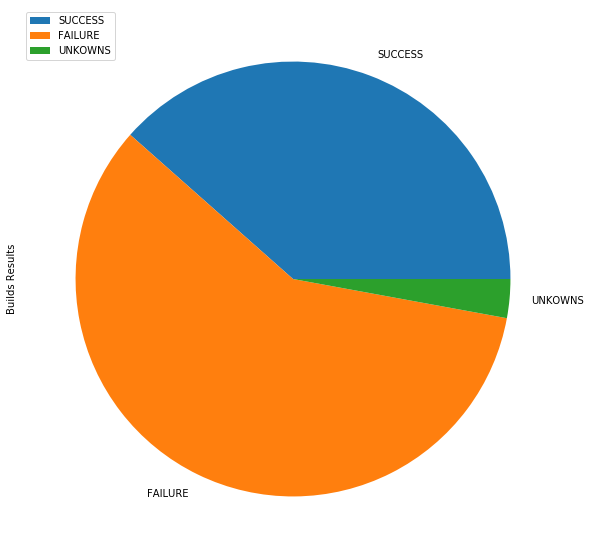

In [7]:
df_result = pd.DataFrame({'Builds Results': [successes, failures, unknows]},
    index=['SUCCESS', 'FAILURE', 'UNKOWNS'])

df_result.plot.pie(y='Builds Results', figsize=(10, 10))
print('')
print('Success Ratio: {0}%'.format(success_ratio))